In [1]:
#Bibliotheken einbinden
import pandas as pd
from pathlib import Path
from numpy.polynomial.polynomial import polyfit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from scipy.stats import weibull_min, weibull_max, norm

# Definieren von Sensorenreihenfolge, -höhe, Bezeichnung in Exceltabellen
sensoren_gesamt = [
    "TL", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9",
    "T10", "T11", "T12", "T13", "T14", "T15", "T16", "T17", "T18", "T19"
]

# Excelbezeichnung (Reihenfolge identisch wie Skizzenliste)
sensoren_excel = [
    "T11", "T6", "T9", "T4", "T15", "T14", "T10", "T17", "T12", "T13",
    "T3", "T19", "T7", "T8", "T18", "T20", "T16", "T1", "T2", "T5"
]

# Umwandeln in Dictionary
skizze_to_excel = dict(zip(sensoren_gesamt, sensoren_excel))
excel_to_skizze = dict(zip(sensoren_excel, sensoren_gesamt))

#Sensoren im Teilquerschnitt nach Skizzenbezeichnung
sensoren_aussen = ["T4", "T5", "T6", "T10", "T11", "T12", "T16", "T18"] # ohne T7-9 (zu extreme Werte)
sensoren_innen = ["T1", "T2", "T3", "T13", "T14", "T15", "T17", "T19"]  # ohne T7-9 (zu extreme Werte)
sensoren_oben = ["T7", "T8", "T9"]
sensoren_links_innen = ["T1", "T2", "T3", "T19"]
sensoren_links_aussen = ["T4", "T5", "T6", "T18"]
sensoren_rechts_innen   = ["T13", "T14", "T15", "T17"]
sensoren_rechts_aussen  = ["T10", "T11", "T12", "T16"]
sensoren_gesamt_ohneOben = [
    s for s in sensoren_gesamt
    if s not in sensoren_oben
]
sensoren_links = sensoren_links_innen + sensoren_links_aussen
sensoren_rechts = sensoren_rechts_innen + sensoren_rechts_aussen

#Sensorhöhen nach Skizzenbezeichnung (UK Stege als 0,00 definiert)
sensor_hoehen = {
"TL": 0.25, #TL
"T1": 1.25, "T2": 0.75, "T3": 0.25, "T4": 0.25, "T5": 0.75, "T6": 1.25, #T1-6
"T7": 1.71, "T8": 1.81, "T9": 1.91, #T7-9
"T10": 1.25, "T11": 0.75, "T12": 0.25, "T13": 0.25, "T14": 0.75, "T15": 1.25, #T10-15
"T16": 1.5, "T17": 1.6, #T16-17
"T18": 1.5, "T19": 1.6, #T18-19
}

# Hilfsfunktion: Daten laden (in Skizzenbezeichnung)
def lade_df(sensorliste, start, ende):
    excel_spalten = [skizze_to_excel[s] for s in sensorliste]
    df = gesamt_df.loc[start:ende, excel_spalten]
    df = df.rename(columns=excel_to_skizze)
    return df[sensorliste]

# Hilfsfunktion: beliebige Liste in Skizzenbezeichnung über die Höhe sortieren
def sensoren_nach_hoehe(sensorliste):
    return sorted(sensorliste, key=lambda s: sensor_hoehen[s])

# Hilfsfunktion: Gradienten berechnen
def berechne_gradient(df, sensorliste):

    #Sensorliste und Höhenliste müssen in gleicher Reihenfolge vorhanden sein
    sensorliste_sortiert = sensoren_nach_hoehe(sensorliste)
    hoehen = np.array([sensor_hoehen[s] for s in sensorliste_sortiert])

    # für Performance: Pandas-DataFrame --> NumPy-Array
    werte = df[sensorliste_sortiert].to_numpy()
    
    gradients = np.full(len(df), np.nan)
    
    # für jeden Zeitschritt wird für jede Sensorliste eine lin. Funktion berechnet (Temp. über Höhe)
    # VEREINFACHUNG: Linearer Temperaturverlauf über die Bauteilhöhe
    for i in range(werte.shape[0]):
        temperaturen = werte[i]
        gueltig = ~np.isnan(temperaturen)

        # Gradient kann nur berechnet werden, wenn min. zwei Sensoren in untersch. Höhen vorh. sind
        if np.sum(gueltig) >= 2:
            # Steigung dT/dz; Einheit: [K/m]
            # Steigung wird gespeichert, andere Werte verworfen
            # WICHTIG: Befinden sich mehrere Sensoren auf derselben Höhe, wirken diese als Stützpunkte mit höherer Gewichtung. Die Regressionsgerade verläuft dann tendenziell durch deren arithmetisches Mittel an diesem Punkt
            steigung, _ = np.polyfit(
                hoehen[gueltig],
                temperaturen[gueltig],
                1
            )
            gradients[i] = steigung
    return pd.Series(gradients, index=df.index)

In [2]:
datein = Path.cwd().glob("*.csv") #Dateipfad für csv-Dateien im selben Ordner wie Skript

cols = ["number", "date", "time"] + [f"T{i}" for i in range(1, 21)] #Kopfzeile erstellen, ersetzt die der csv-Datein

dfs = []

for i in datein:
    try:
        df = pd.read_csv(
            i,
            sep=";",
            encoding="latin1",
            skiprows=2,
            names=cols,
            usecols=range(23),
            on_bad_lines="skip"   # skippen von fehlerbehafteten Zellen
        )
        dfs.append(df)
    except pd.errors.EmptyDataError:
        continue

gesamt_df = pd.concat(dfs, ignore_index=True)

#COdeblock nötig zum bereinigen der dezimaltrenner. Beim Einlesen der CSV-Datein hat 'decimal=","' nicht zuverlässig funktioniert.
#Daher werden hier alle , durch . ersetzt und der String als Zahl abgespeichert

temp_spalten = gesamt_df.filter(like="T").columns #erstellen von einer Liste der Temperaturspalten


gesamt_df[temp_spalten] = ( #Ersetzen
    gesamt_df[temp_spalten]
    .astype(str)
    .replace(",", ".", regex = True)
    .apply(pd.to_numeric, errors="coerce")
)

#Codeblock zum erstellen eines Indexes für alle Zeilen aus spalten "Date" und "Time"

gesamt_df["datetime"] = pd.to_datetime(
    gesamt_df["date"] + " " + gesamt_df["time"],
    format="%d.%m.%Y %H:%M:%S"
)


gesamt_df = gesamt_df.set_index("datetime") #"datetime" als index setzen
gesamt_df = gesamt_df.sort_index() #Dataframe nach "datetime" sortieren

In [3]:
# Plot der Temperaturdifferenzen zu TL
def vergleich_sensoren_TL(start, ende):
    # Sensordaten in Skizzenreihenfolge holen
    werte=lade_df(sensoren_gesamt, start,ende)
    
    # DataFrame mit Skizzenbezeichnungen erzeugen
    df_skizze = pd.DataFrame(
        werte,
        index=gesamt_df.index,
        columns=sensoren_gesamt
    )
    
    # Temperaturdifferenzen relativ zu TL
    df_diff = df_skizze.sub(df_skizze["TL"], axis=0)
    
    df_diff.loc[start:ende].plot(
        figsize=(14, 6),
        title="Temperaturdifferenzen relativ zu TL",
    )
    
    plt.ylabel("ΔT [°C]")
    plt.xlabel("Zeit")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

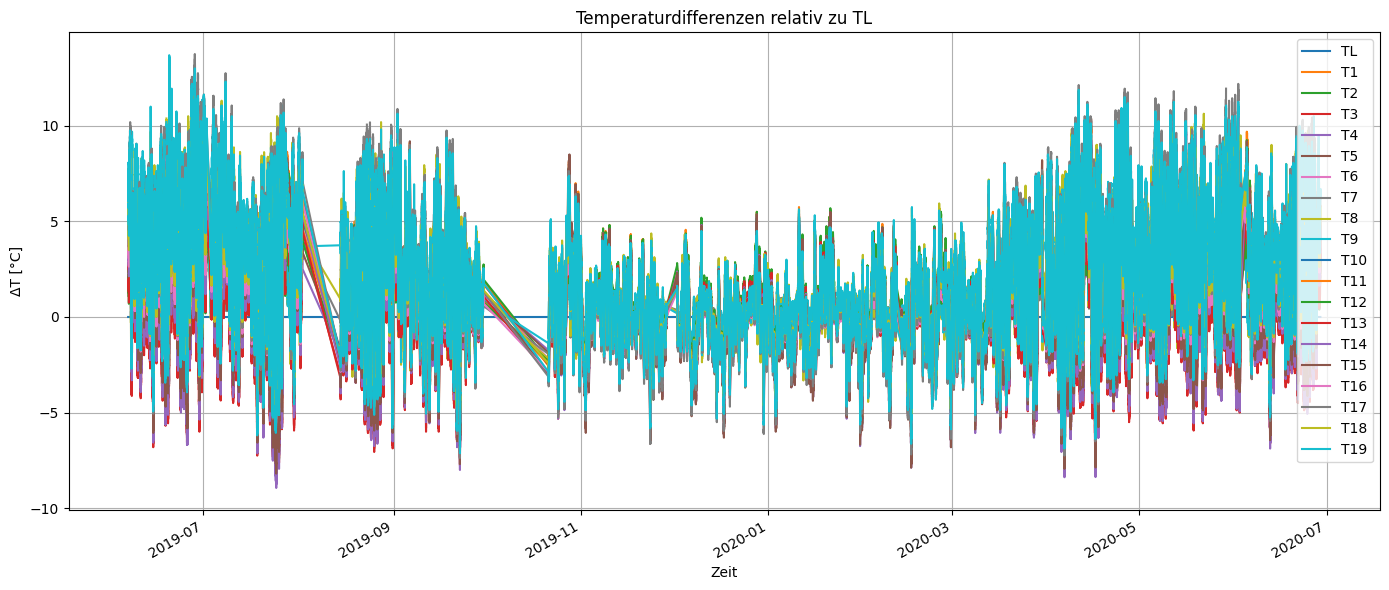

In [4]:
vergleich_sensoren_TL("2019-06-06","2020-06-28")
# erster Überblick über die Sensorenwerte; auch bei folgenden Funktionen war uns Flexibilität bei der Wahl des Zeitraums wichtig --> sehr grobe, übergeordnete Polts über den gesamten Zeitraum vs. detaillierte Plots über ausgewählte Stunden/ Tage/ Wochen/ Monate 
# Brückentemp. unterscheidet sich max. mit 14 K bzw -9 K zur Umgebungstemperatur
# im August, Oktober und Dezember wurden abschnittsweise keine Werte aufgezeichnet
# Abweichungen sind im Winter kleiner als im Sommer (sowohl pos. als auch neg.)

In [5]:
# Plottet mittlere absolute Sensortemperaturen über der Höhe
def plot_mitteltemperaturen(start, ende):
    # Daten laden
    df_skizze = lade_df(sensoren_gesamt, start, ende)
    mittelwerte = df_skizze.mean()

    # Plot
    plt.figure(figsize=(6, 9))

    def plot_gruppe(sensorliste, farbe, label):
        first = True
        for s in sensorliste:
            if s in mittelwerte.index:
                plt.scatter(
                    mittelwerte[s],
                    sensor_hoehen[s],
                    color=farbe,
                    s=60,
                    label=label if first else None
                )
                plt.text(
                    mittelwerte[s] - 0.07,
                    sensor_hoehen[s] + 0.03,
                    s,
                    fontsize=9,
                    va="center"
                )
                first = False

    plot_gruppe(sensoren_links, "green", "linker Teilquerschnitt")
    plot_gruppe(sensoren_rechts, "purple", "rechter Teilquerschnitt")
    plot_gruppe(sensoren_oben, "orange", "obere Sensoren")


    # Achsen & Layout
    plt.xlabel("Temperatur [°C]")
    plt.ylabel("Höhe z [m]")
    plt.grid(True)
    plt.legend()
    plt.title("Mittlere Sensortemperaturen\n"+start+" bis "+ende)
    plt.tight_layout()
    plt.show()

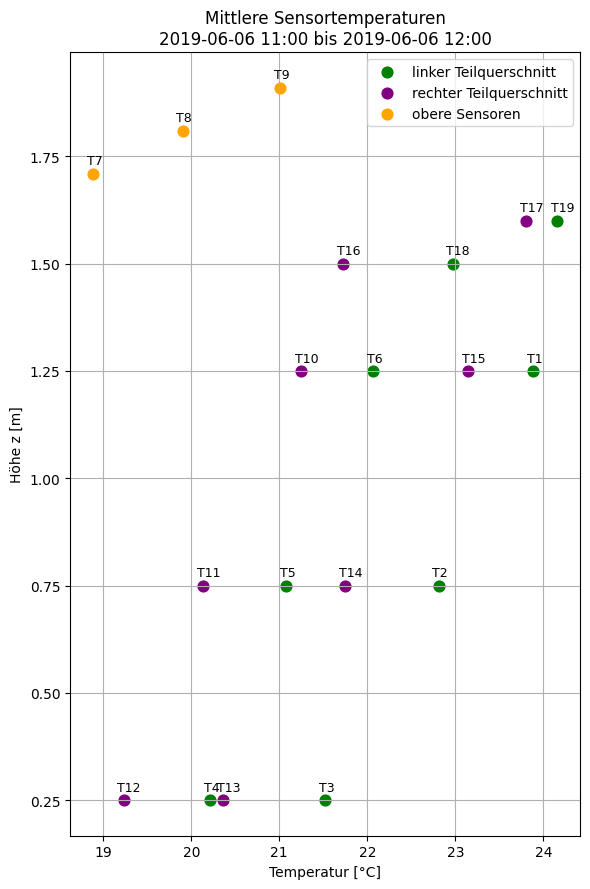

In [6]:
plot_mitteltemperaturen(
    "2019-06-06 11:00",
    "2019-06-06 12:00",
)
# Sensoren im linken Teil-QS sind an dem Morgen ca 1 K wärmer als die gespiegelten Sensoren im rechten Teil-QS --> wird von der Sonne aus dem Osten bestrahlt
# Fahrbahn wird ebenso von der Sonne (im kleineren Winkel) getroffen --> Temperaturgradient von T9-T7; Wärme wird in Bauteilinneres getragen
# unten ist es nach der Nacht tendentiell kälter

In [7]:
"""
    Plottet vereinheitlichte Temperatur-Heatmaps:
    1) Gesamtquerschnitt absolut (nach Höhe sortiert)
    2) ΔT linker Teilquerschnitt relativ zum Gesamt-QS
    3) ΔT rechter Teilquerschnitt relativ zum Gesamt-QS
    4) Gesamtquerschnitt relativ zu TL
"""
def plot_temperatur_heatmap(start, ende):
    df_gesamt = lade_df(sensoren_gesamt, start, ende)
    df_links  = lade_df(sensoren_links, start, ende)
    df_rechts = lade_df(sensoren_rechts, start, ende)

    # Colormaps
    cmap_abs = mcolors.LinearSegmentedColormap.from_list(
        "abs",
        ["black", "darkblue", "turquoise", "green", "yellow", "red"]
    )

    cmap_delta = mcolors.LinearSegmentedColormap.from_list(
        "delta",
        ["cyan", "blue", "white", "orange", "red"]
    )

    # Zeitachse
    xticks = np.linspace(0, len(df_gesamt.index) - 1, 10)
    xtick_labels = [
        df_gesamt.index[int(i)].strftime("%d.%m.%Y %H:%M")
        for i in xticks
    ]

    # Die Liste der Sensoren nach Höhe sortieren
    # diese Liste dient als Index für die Spalten
    sensoren_sortiert = sensoren_nach_hoehe(sensoren_gesamt)
    
    # Mittelwert über alle Sensoren für die relativen Plots 3 und 4
    gesamt_mittel = df_gesamt.mean(axis=1)
    
    # PLOT 1: Heatmap – Gesamt absolut; nach Höhe sortiert
    plt.figure(figsize=(14, 6))
    
    # df_gesamt[sensoren_sortiert] sortiert die Spalten, .T macht sie zur Y-Achse
    im = plt.imshow(df_gesamt[sensoren_sortiert].T, aspect="auto", origin="lower", cmap=cmap_abs)
    plt.colorbar(im, label="Temperatur [°C]")
    
    plt.yticks(
        np.arange(len(sensoren_sortiert)),
        [f"{s} (z={sensor_hoehen[s]:.2f} m)" for s in sensoren_sortiert]
    )
    plt.xticks(xticks, xtick_labels, rotation=45)
    
    plt.xlabel("Zeit")
    plt.ylabel("Sensor (nach Höhe sortiert)")
    plt.title("Absolute Temperaturen im Gesamtquerschnitt")
    plt.tight_layout()
    plt.show()
    
    
    # PLOT 2: Heatmap – Gesamt relativ zu TL; nach Höhe sortiert
    df_gesamt_relativ = df_gesamt.sub(df_gesamt["TL"], axis=0)
    df_plot_relativ = df_gesamt_relativ[sensoren_sortiert]
    
    vmax = np.nanmax(np.abs(df_plot_relativ.values))
    
    plt.figure(figsize=(14, 6))
    im = plt.imshow(
        df_plot_relativ.T, 
        aspect="auto", 
        origin="lower", 
        cmap=cmap_delta, 
        vmin=-vmax, 
        vmax=vmax
    )
    plt.colorbar(im, label="ΔT relativ zu TL [°C]")
    
    plt.yticks(
        np.arange(len(sensoren_sortiert)),
        [f"{s} (z={sensor_hoehen[s]:.2f} m)" for s in sensoren_sortiert]
    )
    plt.xticks(xticks, xtick_labels, rotation=45)
    
    plt.xlabel("Zeit")
    plt.ylabel("Sensor (nach Höhe sortiert)")
    plt.title("Gesamtquerschnitt in Relation zu TL")
    plt.tight_layout()
    plt.show()

    # PLOT 3 Heatmap – Links relativ zu Gesamt
    df_links_relativ = df_links.sub(gesamt_mittel, axis=0)
    
    # Spalten nach Höhe sortieren
    sensoren_links_sortiert = sensoren_nach_hoehe(list(df_links_relativ.columns))
    df_links_relativ = df_links_relativ[sensoren_links_sortiert]

    vmax = np.nanmax(np.abs(df_links_relativ.values))

    plt.figure(figsize=(14, 6))
    im = plt.imshow(
        df_links_relativ.T,
        aspect="auto",
        origin="lower",
        cmap=cmap_delta,
        vmin=-vmax,
        vmax=vmax
    )
    plt.colorbar(im, label="ΔT links – Gesamt [°C]")

    # Y-Ticks passend zur sortierten Liste setzen
    plt.yticks(
        np.arange(len(sensoren_links_sortiert)),
        [f"{s} (z={sensor_hoehen[s]:.2f} m)" for s in sensoren_links_sortiert]
    )
    plt.xticks(xticks, xtick_labels, rotation=45)

    plt.xlabel("Zeit")
    plt.ylabel("Sensor")
    plt.title("Linker Teilquerschnitt in Relation zum Gesamtquerschnitt")
    plt.tight_layout()
    plt.show()

    # PLOT 4 Heatmap – Rechts relativ zu Gesamt
    df_rechts_relativ = df_rechts.sub(gesamt_mittel, axis=0)
    
    # Spalten nach Höhe sortieren
    sensoren_rechts_sortiert = sensoren_nach_hoehe(list(df_rechts_relativ.columns))
    df_rechts_relativ = df_rechts_relativ[sensoren_rechts_sortiert]

    vmax = np.nanmax(np.abs(df_rechts_relativ.values))

    plt.figure(figsize=(14, 6))
    im = plt.imshow(
        df_rechts_relativ.T,
        aspect="auto",
        origin="lower",
        cmap=cmap_delta,
        vmin=-vmax,
        vmax=vmax
    )
    plt.colorbar(im, label="ΔT rechts – Gesamt [°C]")

    # Y-Ticks passend zur sortierten Liste setzen
    plt.yticks(
        np.arange(len(sensoren_rechts_sortiert)),
        [f"{s} (z={sensor_hoehen[s]:.2f} m)" for s in sensoren_rechts_sortiert]
    )
    plt.xticks(xticks, xtick_labels, rotation=45)

    plt.xlabel("Zeit")
    plt.ylabel("Sensor")
    plt.title("Rechter Teilquerschnitt in Relation zum Gesamtquerschnitt")
    plt.tight_layout()
    plt.show()

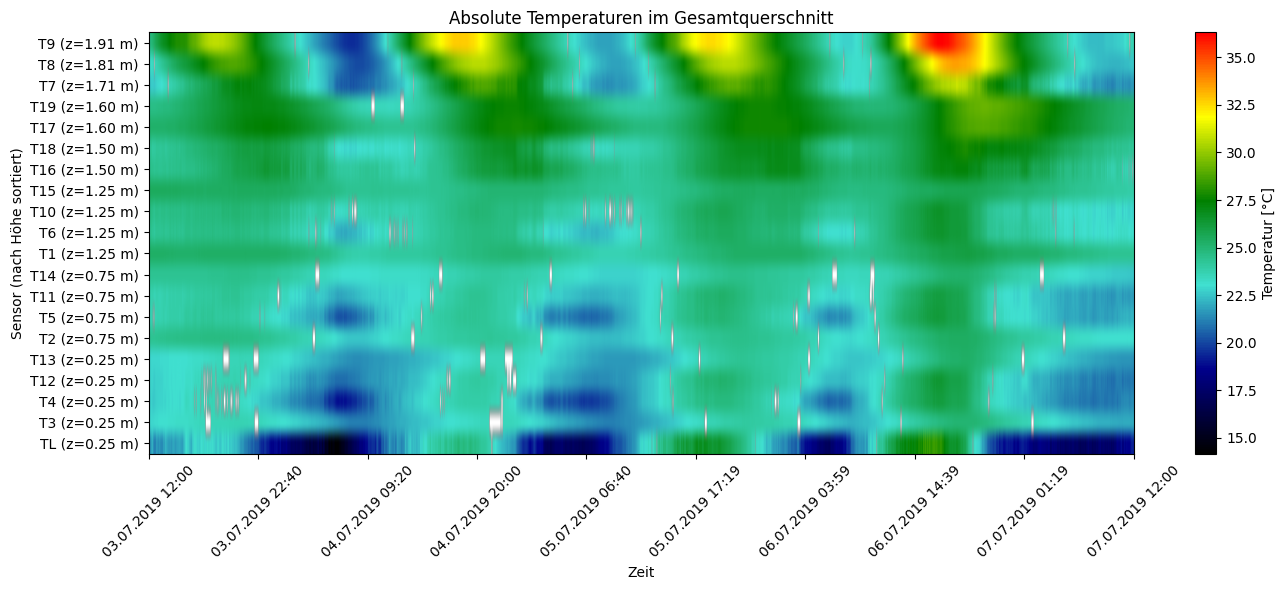

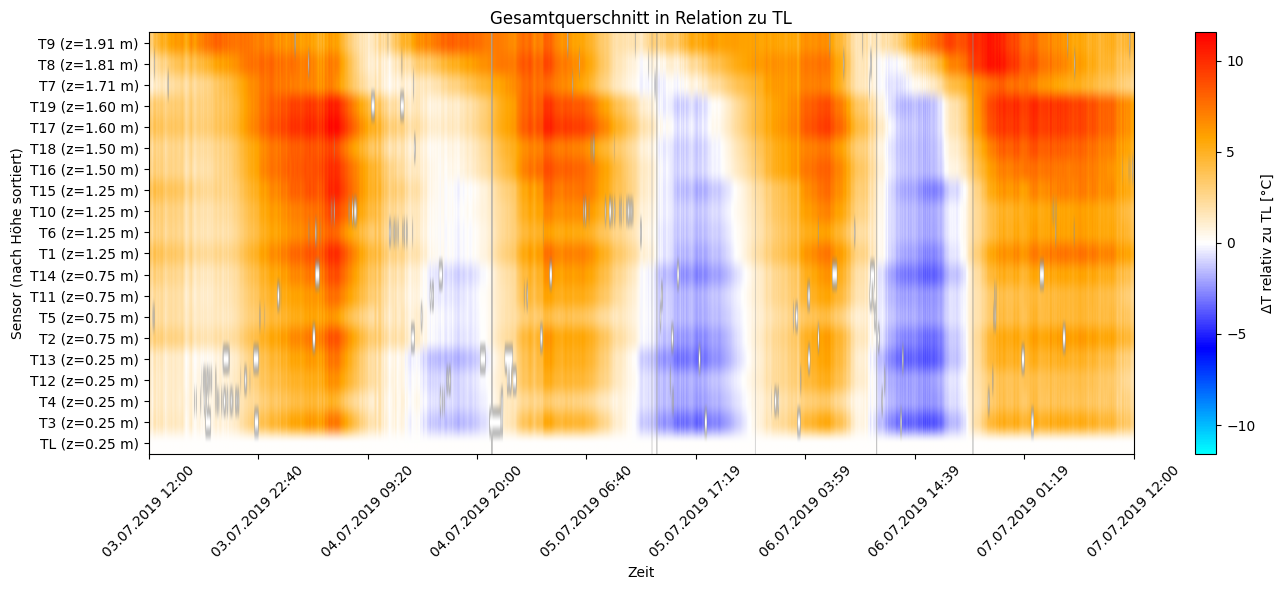

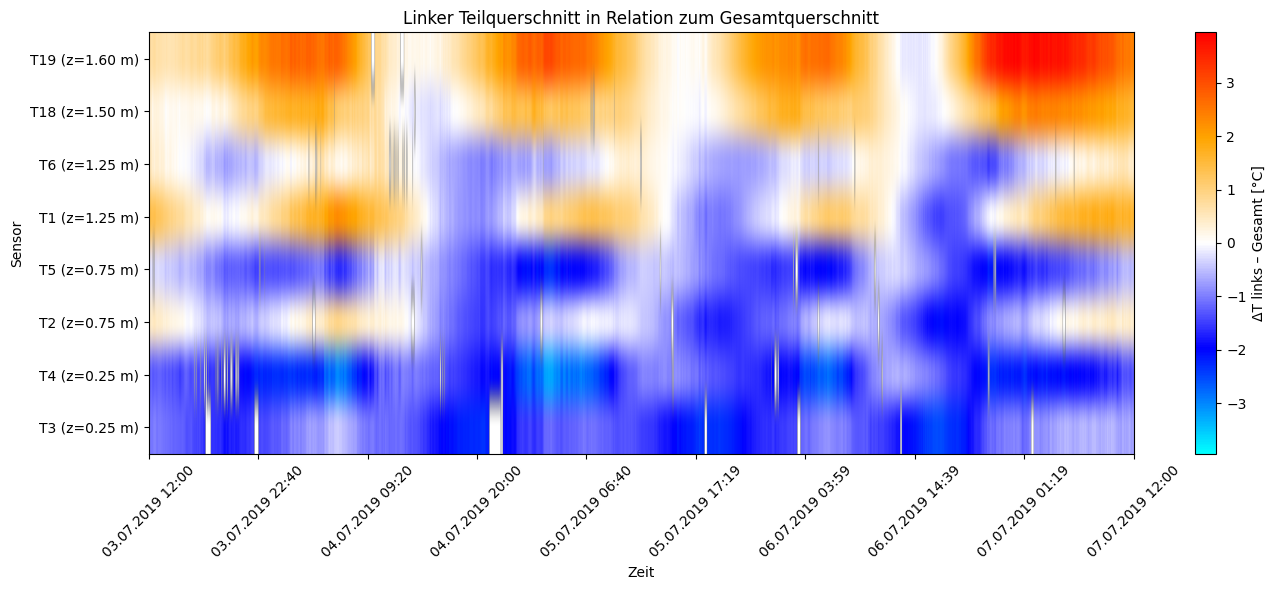

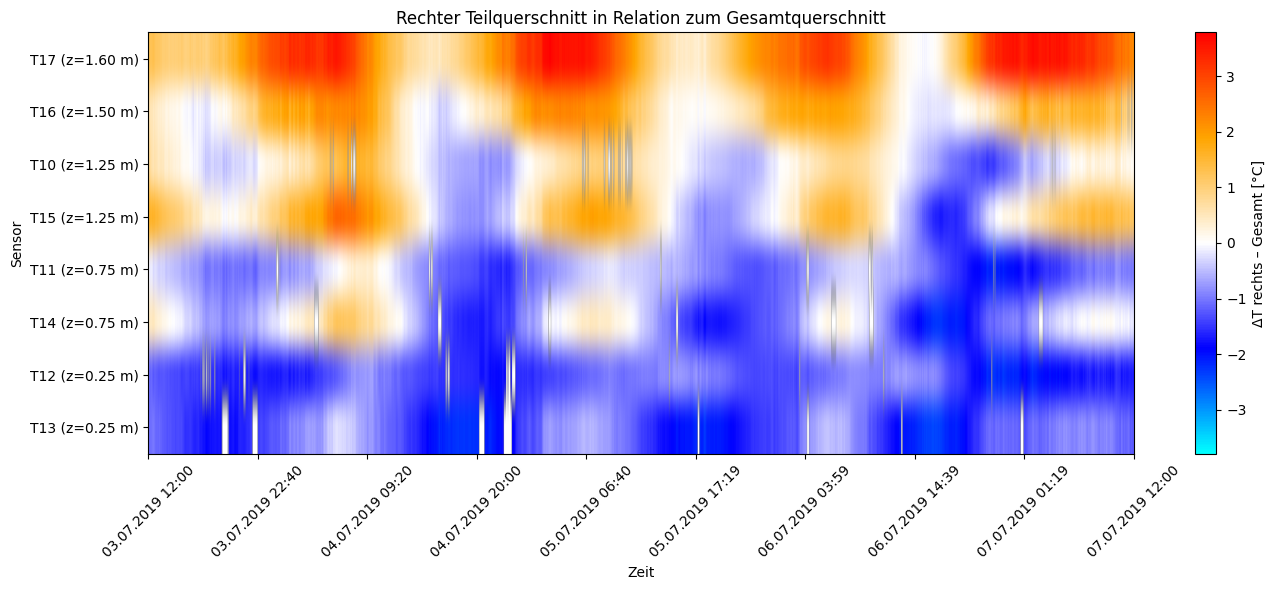

In [8]:
# Heatmaps zu Gesamt- und Teilquerschnitt
# absolut und relativ
plot_temperatur_heatmap("2019-07-03 12:00", "2019-07-07  12:00")
# Allgemein

# Sommer
# oben tagsüber mit Abstand am wärmsten --> direkte Sonneneinstrahlung; nachts fällt Temp. schnell wieder auf Umgebungstemperatur
# Außensensoren schwanken stärker als Innensensoren, insb. bei kurzfristigen Ereignissen (Wechsel zwischen Sonne, Wolken, Regen, Wind)
# je tiefer Sensoren im Bauteilinneren liegen, desto später erreichen sie Temperaturänderungen

In [9]:
def temperaturgradient(start, ende):
    
    # ---------------------------------------
    # Daten laden (Skizzenbezeichnung)
    # ---------------------------------------
    df_skizze = lade_df(sensoren_gesamt, start, ende)

    grad_gesamt_ohneOben  = berechne_gradient(df_skizze, sensoren_gesamt_ohneOben)
    grad_links   = berechne_gradient(df_skizze, sensoren_links)
    grad_rechts  = berechne_gradient(df_skizze, sensoren_rechts)
    grad_aussen  = berechne_gradient(df_skizze, sensoren_aussen)
    grad_innen   = berechne_gradient(df_skizze, sensoren_innen)
    grad_oben    = berechne_gradient(df_skizze, sensoren_oben)

    grad_links_innen   = berechne_gradient(df_skizze, sensoren_links_innen)
    grad_links_aussen  = berechne_gradient(df_skizze, sensoren_links_aussen)
    grad_rechts_innen   = berechne_gradient(df_skizze, sensoren_rechts_innen)
    grad_rechts_aussen  = berechne_gradient(df_skizze, sensoren_rechts_aussen)
    
    # PLOT 1 - ÜBERBLICK
    plt.figure(figsize=(14, 5))
    plt.plot(
        grad_gesamt_ohneOben,
        color="silver",
        linewidth=2.2,
        label="Gradient gesamt"
    )
    
    plt.plot(
        grad_links,
        color="red",
        linewidth=1.6,
        label="Gradient links"
    )
    
    plt.plot(
        grad_rechts,
        color="darkred",
        linewidth=1.6,
        label="Gradient rechts"
    )

    plt.plot(
        grad_innen,
        linestyle=":",
        color="blue",
        linewidth=1.6,
        label="Gradient innen"
    )

    plt.plot(
        grad_aussen,
        linestyle=":",
        color="darkblue",
        linewidth=1.6,
        label="Gradient außen"
    )
    
    plt.axhline(0, color="grey", linewidth=0.8)

    plt.ylabel("Temperaturgradient dT/dz [K/m]")
    plt.xlabel("Zeit")
    plt.title("Übersicht der Temperaturgradienten (ohne TL und obere Sensoren)")
    plt.grid(True)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

    # PLOT 2 - LINKS
    plt.figure(figsize=(14, 5))
    plt.plot(
        grad_gesamt_ohneOben,
        color="silver",
        linewidth=2.2,
        label="Gradient gesamt"
    )
    
    plt.plot(
        grad_links,
        color="red",
        linewidth=1.6,
        label="Gradient links"
    )

    plt.plot(
        grad_links_innen,
        color="steelblue",
        linewidth=1.6,
        label="Gradient links innen"
    )

    plt.plot(
        grad_links_aussen,
        color="skyblue",
        linewidth=1.6,
        label="Gradient links außen"
    )
    
    plt.axhline(0, color="grey", linewidth=0.8)

    plt.ylabel("Temperaturgradient dT/dz [K/m]")
    plt.xlabel("Zeit")
    plt.title("Rechter Teil-QS über die Zeit")
    plt.grid(True)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

    # PLOT 3 - RECHTS
    plt.figure(figsize=(14, 5))
    plt.plot(
        grad_gesamt_ohneOben,
        color="silver",
        linewidth=2.2,
        label="Gradient gesamt"
    )
    
    plt.plot(
        grad_rechts,
        color="darkred",
        linewidth=1.6,
        label="Gradient rechts"
    )

    plt.plot(
        grad_rechts_innen,
        color="steelblue",
        linewidth=1.6,
        label="Gradient rechts innen"
    )

    plt.plot(
        grad_rechts_aussen,
        color="skyblue",
        linewidth=1.6,
        label="Gradient rechts außen"
    )
    
    plt.axhline(0, color="grey", linewidth=0.8)

    plt.ylabel("Temperaturgradient dT/dz [K/m]")
    plt.xlabel("Zeit")
    plt.title("Linker Teil-QS über die Zeit")
    plt.grid(True)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

    # PLOT 4 - OBEN
    plt.figure(figsize=(14, 5))
    plt.plot(
        grad_gesamt_ohneOben,
        color="silver",
        linewidth=2.2,
        label="Gradient gesamt"
    )
    
    plt.plot(
        grad_oben,
        linestyle="--",
        color="gold",
        linewidth=1.6,
        label="Gradient oben"
    )

    plt.axhline(0, color="grey", linewidth=0.8)

    plt.ylabel("Temperaturgradient dT/dz [K/m]")
    plt.xlabel("Zeit")
    plt.title("obere Platte über die Zeit")
    plt.grid(True)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()  


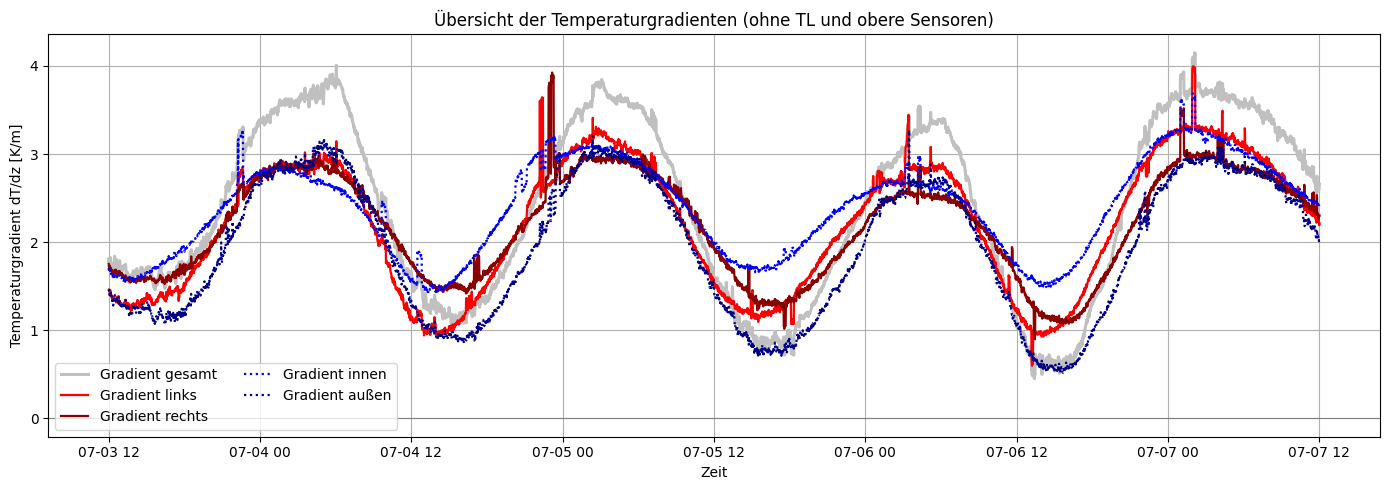

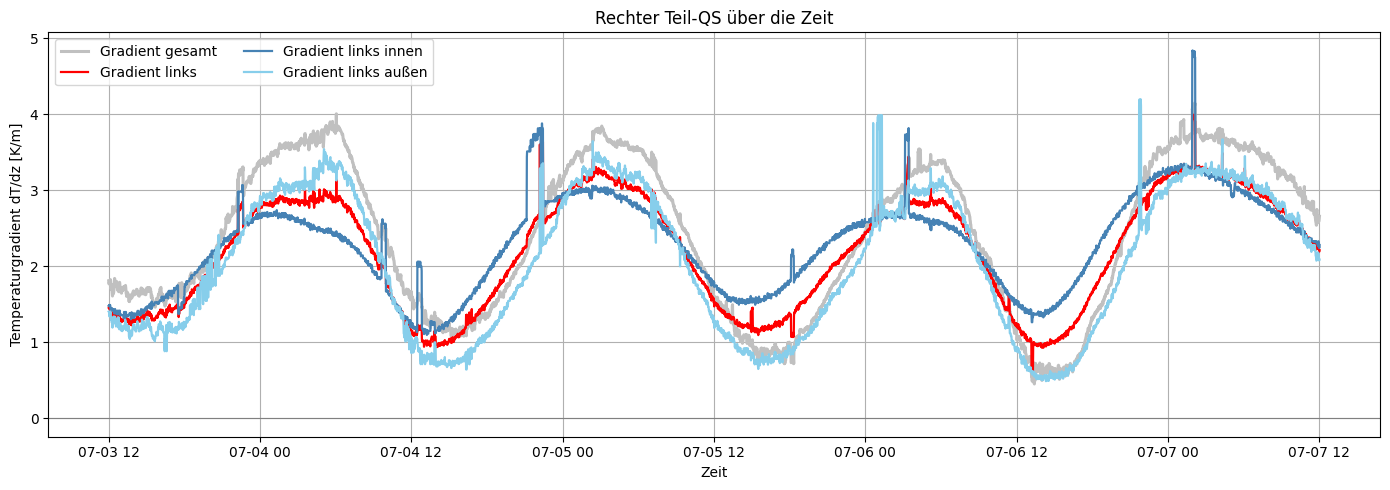

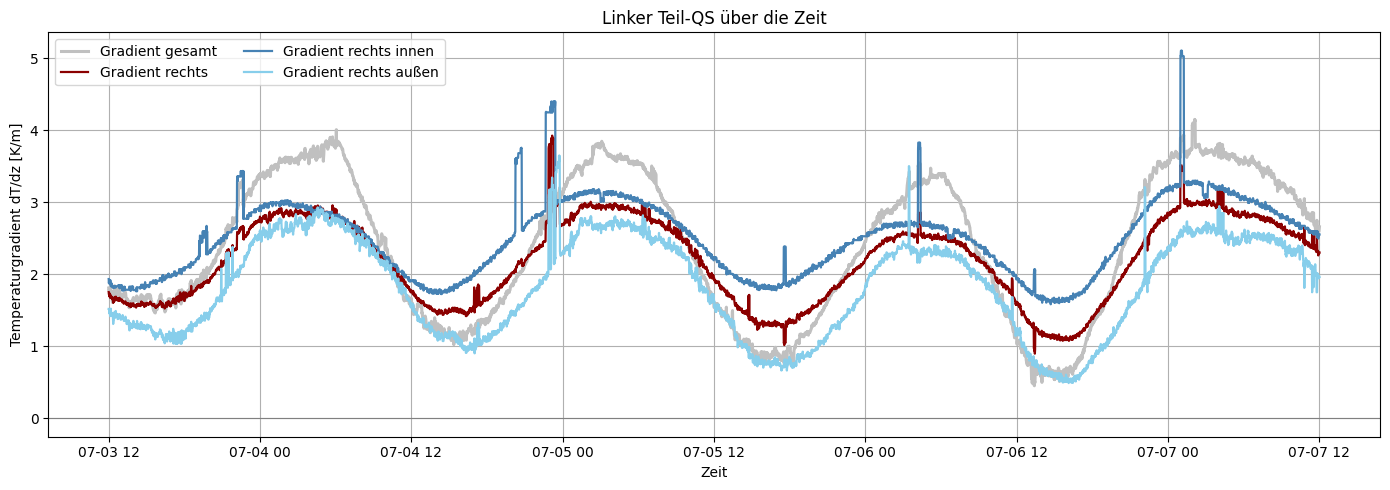

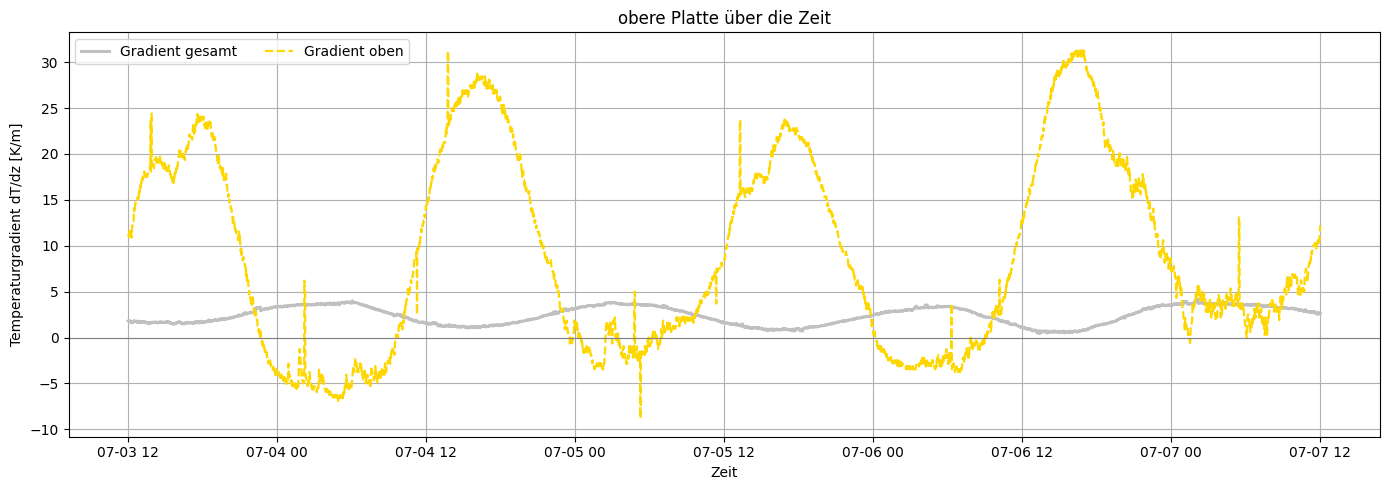

In [10]:
temperaturgradient("2019-07-03 12:00", "2019-07-07  12:00")

In [11]:
#Aufgabe 2

In [12]:
def drei_tages_maxmin(sensoren, start, ende, auszuwertendeDaten):

    if auszuwertendeDaten == "gradient":
        
        df_maxmin3 = lade_df(sensoren, start, ende)
        
        hoehen = sensoren_nach_hoehe(df_maxmin3)
        
        grad_3d = berechne_gradient(df_maxmin3, hoehen)
    
        grad_3d = grad_3d.dropna().sort_index()
        
        block = grad_3d.groupby(pd.Grouper(freq="3D"))
        max3 = block.max().dropna()
        min3 = block.min().dropna()
        
        plt.figure(figsize=(14,5))
        plt.plot(grad_3d.index, grad_3d.values, label="Gradient")
        
        plt.scatter(max3.index, max3.values, s=18, label="3 Tages-Maxima")
        plt.scatter(min3.index, min3.values, s=18, label="3 Tages-Minima")
        
        plt.title("Gradient 3-Tage-Extremwerte")
        plt.xlabel("Zeit")
        plt.ylabel("Gradient")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    elif auszuwertendeDaten == "temperatur":
        
        df = lade_df(sensoren, start, ende).dropna(how="all").sort_index()
        
        abs_max_t = df.max(axis=1)   
        abs_min_t = df.min(axis=1)   
    

        block_max = abs_max_t.groupby(pd.Grouper(freq="3D"))
        block_min = abs_min_t.groupby(pd.Grouper(freq="3D"))
    
        max3 = block_max.max().dropna()   # absolutes 3T-Maximum
        min3 = block_min.min().dropna()   # absolutes 3T-Minimum
    
        
        plt.figure(figsize=(14,5))
        plt.plot(abs_max_t.index, abs_max_t.values, alpha=0.7, label="abs. Max über Sensoren")
        plt.plot(abs_min_t.index, abs_min_t.values, alpha=0.7, label="abs. Min über Sensoren")
    
        plt.scatter(max3.index, max3.values, s=18, label="3 Tages-Maxima (abs.)")
        plt.scatter(min3.index, min3.values, s=18, label="3 Tages-Minima (abs.)")
        
        plt.title("Absolute 3-Tage-Extremwerte über alle Sensoren")
        plt.xlabel("Zeit")
        plt.ylabel("Temperatur / Größe")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

    else:
        print("Fehler")
    
    return max3, min3

def schnelleauswertung(sensoren, auszuwertendeDaten, Kurzbeschreibung): #Funktion zur Auswertung ohne Grafiken

    start = gesamt_df.index.min()
    end   = gesamt_df.index.max()
    
    if auszuwertendeDaten == "gradient":
        
        df_maxmin3 = lade_df(sensoren, start, end)
        
        hoehen = sensoren_nach_hoehe(df_maxmin3)
        
        grad_3d = berechne_gradient(df_maxmin3, hoehen)
    
        grad_3d = grad_3d.dropna().sort_index()
        
        block = grad_3d.groupby(pd.Grouper(freq="3D"))
        max3 = block.max().dropna()
        min3 = block.min().dropna()  
        
    elif auszuwertendeDaten == "temperatur":
        
        df = lade_df(sensoren, start, end).dropna(how="all").sort_index()
        
        abs_max_t = df.max(axis=1)   
        abs_min_t = df.min(axis=1)   
    

        block_max = abs_max_t.groupby(pd.Grouper(freq="3D"))
        block_min = abs_min_t.groupby(pd.Grouper(freq="3D"))
    
        max3 = block_max.max().dropna()   # absolutes 3T-Maximum
        min3 = block_min.min().dropna()   # absolutes 3T-Minimum

    else:
        print("Fehler")
        
    x = max3.values
    c, loc, scale = weibull_min.fit(x)
    
    
    
    #Bestimmung Charakterischer Wert
    q_k = 0.98 #98%-Quantil der Jahresextremwertverteilung
    n_k = (3/365.25)/1
    
    q_k_3d = q_k**n_k
    
    
    P_k = weibull_min.ppf(q_k_3d, c, loc=loc, scale=scale)
    
    #Bestimmung Bemessungswert
    
    t2 = 50 #50-Jaehriger Bemessungszeitraum
    t1 = 3/365.25 #Bezug 3 Tagesextrema auf ein Jahr
    beta50 = 3.8 #Bemessungszeitraum 50 Jahre
    alphaE = -0.7 # Aus Folien übernommen
    
    n_d = t1/t2
    
    q_d_3d =  (norm.cdf(-alphaE * beta50)) ** n_d
    
    P_d = weibull_min.ppf(q_d_3d, c, loc=loc, scale=scale)
    
    gamma = P_d/P_k #Berechnung Teilsicherheitsbeiwert
    print("______" + Kurzbeschreibung + "______")
    print(f"Weibull-Fit: shape(c)={c:.6f}, loc={loc:.6f}, scale={scale:.6f}")
    print(f"P_k (p_k_3d={q_k_3d:.8f})  = {P_k:.4f}")
    print(f"P_d (p_d_3d={q_d_3d:.8f})  = {P_d:.4f}")
    print(f"gamma = {gamma:.4f}")

def auswerten(werte, auszuwertendeDaten, Weibullminmax):
    x = werte.values

    if Weibullminmax == "min":

        c, loc, scale = weibull_min.fit(x)

        #print(f"Weibull-Fit: shape(c)={c:.6f}, loc={loc:.6f}, scale={scale:.6f}")
        
        
        #Bestimmung Charakterischer Wert
        q_k = 0.98 #98%-Quantil der Jahresextremwertverteilung
        n_k = (3/365.25)/1
        
        q_k_3d = q_k**n_k
        
        
        Tgrad_k = weibull_min.ppf(q_k_3d, c, loc=loc, scale=scale)
        
        
        #Bestimmung Bemessungswert
        
        t2 = 50 #50-Jaehriger Bemessungszeitraum
        t1 = 3/365.25 #Bezug 3 Tagesextrema auf ein Jahr
        beta50 = 3.8 #Bemessungszeitraum 50 Jahre
        alphaE = -0.7 # Aus Folien übernommen
        
        n_d = t1/t2
        
        q_d_3d =  (norm.cdf(-alphaE * beta50)) ** n_d
        
        Tgrad_d = weibull_min.ppf(q_d_3d, c, loc=loc, scale=scale)
        
        gamma = Tgrad_d/Tgrad_k #Berechnung Teilsicherheitsbeiwert

        if auszuwertendeDaten == "gradient":
            
            print(f"Weibull-Fit: shape(c)={c:.6f}, loc={loc:.6f}, scale={scale:.6f}")
            print(f"Tgrad_k (p_k_3d={q_k_3d:.8f})  = {Tgrad_k:.4f}")
            print(f"Tgrad_d (p_d_3d={q_d_3d:.8f})  = {Tgrad_d:.4f}")
            print(f"gamma = {gamma:.4f}")
            
            xs = np.linspace(loc, x.max()*1.5, 300)
            
            plt.figure(figsize=(8,4))
            plt.hist(x, bins=12, density=True, alpha=0.5, label="Maximalwerte Temperaturgradient 3 Tage (Histogramm)")
            plt.plot(xs, weibull_min.pdf(xs, c, loc=loc, scale=scale), label="Weibull_min-Fit (PDF)")
            plt.axvline(Tgrad_k, linestyle="--", linewidth=2, label=f"Tgrad_k = {Tgrad_k:.2f}")
            plt.axvline(Tgrad_d, linestyle=":",  linewidth=2, label=f"Tgrad_d = {Tgrad_d:.2f}")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
        elif auszuwertendeDaten == "temperatur":
            
            print(f"Weibull-Fit: shape(c)={c:.6f}, loc={loc:.6f}, scale={scale:.6f}")
            print(f"T_k (p_k_3d={q_k_3d:.8f})  = {Tgrad_k:.4f}")
            print(f"T_d (p_d_3d={q_d_3d:.8f})  = {Tgrad_d:.4f}")
            print(f"gamma = {gamma:.4f}")
            
            xs = np.linspace(loc, x.max()*1.5, 300)
            
            plt.figure(figsize=(8,4))
            plt.hist(x, bins=12, density=True, alpha=0.5, label="Maximalwerte Temperatur 3 Tage (Histogramm)")
            plt.plot(xs, weibull_min.pdf(xs, c, loc=loc, scale=scale), label="Weibull_min-Fit (PDF)")
            plt.axvline(Tgrad_k, linestyle="--", linewidth=2, label=f"T_k = {Tgrad_k:.2f}")
            plt.axvline(Tgrad_d, linestyle=":",  linewidth=2, label=f"T_d = {Tgrad_d:.2f}")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
    elif Weibullminmax == "max":
        
        c, loc, scale = weibull_max.fit(x)
        
        #Bestimmung Charakterischer Wert
        q_k = 0.98 #98%-Quantil der Jahresextremwertverteilung
        n_k = (3/365.25)/1
        
        q_k_3d = q_k**n_k
        
        
        Tgrad_k = weibull_max.ppf(q_k_3d, c, loc=loc, scale=scale)
        
        
        #Bestimmung Bemessungswert
        
        t2 = 50 #50-Jaehriger Bemessungszeitraum
        t1 = 3/365.25 #Bezug 3 Tagesextrema auf ein Jahr
        beta50 = 3.8 #Bemessungszeitraum 50 Jahre
        alphaE = -0.7 # Aus Folien übernommen
        
        n_d = t1/t2
        
        q_d_3d =  (norm.cdf(-alphaE * beta50)) ** n_d
        
        Tgrad_d = weibull_max.ppf(q_d_3d, c, loc=loc, scale=scale)
        
        gamma = Tgrad_d/Tgrad_k #Berechnung Teilsicherheitsbeiwert


        if auszuwertendeDaten == "gradient":

            print(f"Weibull-Fit: shape(c)={c:.6f}, loc={loc:.6f}, scale={scale:.6f}")
            print(f"Tgrad_k (p_k_3d={q_k_3d:.8f})  = {Tgrad_k:.4f}")
            print(f"Tgrad_d (p_d_3d={q_d_3d:.8f})  = {Tgrad_d:.4f}")
            print(f"gamma = {gamma:.4f}")
    
            xs = np.linspace(x.min(), loc, 300)
            
            plt.figure(figsize=(8,4))
            plt.hist(x, bins=12, density=True, alpha=0.5, label="Maximalwerte Temepraturgradient 3 Tage (Histogramm)")
            plt.plot(xs, weibull_max.pdf(xs, c, loc=loc, scale=scale), label="Weibull_max-Fit (PDF)")
            plt.axvline(Tgrad_k, linestyle="--", linewidth=2, label=f"Tgrad_k = {Tgrad_k:.2f}")
            plt.axvline(Tgrad_d, linestyle=":",  linewidth=2, label=f"Tgrad_d = {Tgrad_d:.2f}")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
        elif auszuwertendeDaten == "temperatur":
            print(f"Weibull-Fit: shape(c)={c:.6f}, loc={loc:.6f}, scale={scale:.6f}")
            print(f"T_k (p_k_3d={q_k_3d:.8f})  = {Tgrad_k:.4f}")
            print(f"T_d (p_d_3d={q_d_3d:.8f})  = {Tgrad_d:.4f}")
            print(f"gamma = {gamma:.4f}")
    
            xs = np.linspace(x.min(), loc, 300)
            
            plt.figure(figsize=(8,4))
            plt.hist(x, bins=12, density=True, alpha=0.5, label="Maximalwerte Temperatue 3 Tage (Histogramm)")
            plt.plot(xs, weibull_max.pdf(xs, c, loc=loc, scale=scale), label="Weibull_max-Fit (PDF)")
            plt.axvline(Tgrad_k, linestyle="--", linewidth=2, label=f"T_k = {Tgrad_k:.2f}")
            plt.axvline(Tgrad_d, linestyle=":",  linewidth=2, label=f"T_d = {Tgrad_d:.2f}")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        

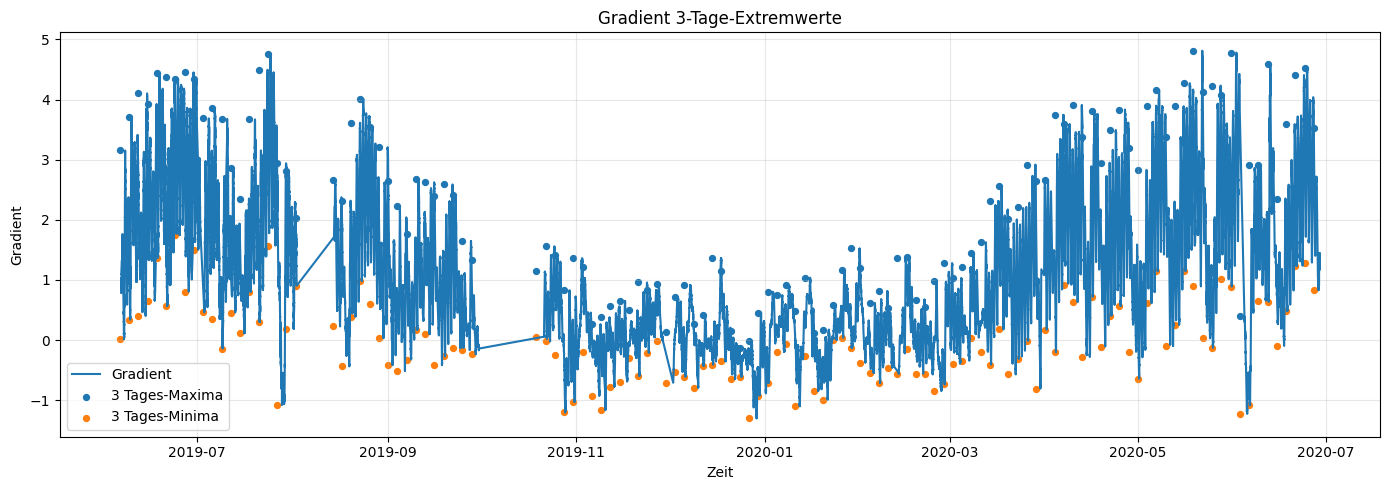

Weibull-Fit: shape(c)=1.857907, loc=-0.305659, scale=2.936300
Tgrad_k (p_k_3d=0.99983408)  = 9.1044
Tgrad_d (p_d_3d=0.99999936)  = 11.9672
gamma = 1.3144


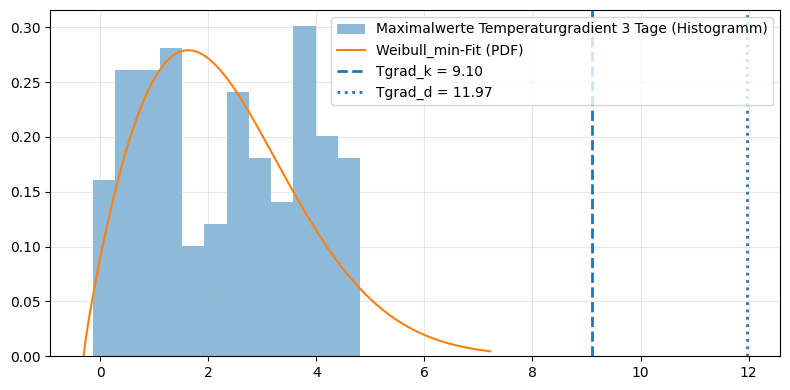

In [13]:

start = gesamt_df.index.min()
end   = gesamt_df.index.max()

sensoren_alle = sensoren_links + sensoren_rechts + sensoren_oben

max3, min3 = drei_tages_maxmin(sensoren_alle, start, end, "gradient") # als letztes Argument entweder "temperatur" oder "gradient"

auswerten(max3, "gradient", "min") #Eingabe Weibull min oder max Auswertung

In [14]:


#Vergleich der verschiedenen Sensoranrodnungen
schnelleauswertung(sensoren_alle, "gradient", "ALLE")
schnelleauswertung(sensoren_links, "gradient", "Links")
schnelleauswertung(sensoren_links_aussen, "gradient", "Links_aussen")
schnelleauswertung(sensoren_links_innen, "gradient", "Links_innen")
schnelleauswertung(sensoren_rechts, "gradient", "Rechts")
schnelleauswertung(sensoren_rechts_aussen, "gradient", "Rechts_aussen")
schnelleauswertung(sensoren_rechts_innen, "gradient", "Rechts_innen")

sensoren_testinnen = sensoren_innen + sensoren_oben
sensoren_testaussen = sensoren_aussen + sensoren_oben
schnelleauswertung(sensoren_testinnen, "gradient", "innen + oben")
schnelleauswertung(sensoren_testaussen, "gradient", "aussen + oben")


______ALLE______
Weibull-Fit: shape(c)=1.857907, loc=-0.305659, scale=2.936300
P_k (p_k_3d=0.99983408)  = 9.1044
P_d (p_d_3d=0.99999936)  = 11.9672
gamma = 1.3144
______Links______
Weibull-Fit: shape(c)=1.694468, loc=-0.255158, scale=2.385527
P_k (p_k_3d=0.99983408)  = 8.2988
P_d (p_d_3d=0.99999936)  = 11.1905
gamma = 1.3485
______Links_aussen______
Weibull-Fit: shape(c)=1.040077, loc=0.359200, scale=1.972874
P_k (p_k_3d=0.99983408)  = 16.1574
P_d (p_d_3d=0.99999936)  = 25.7491
gamma = 1.5936
______Links_innen______
Weibull-Fit: shape(c)=1.367048, loc=-0.203233, scale=2.261911
P_k (p_k_3d=0.99983408)  = 10.8092
P_d (p_d_3d=0.99999936)  = 15.5966
gamma = 1.4429
______Rechts______
Weibull-Fit: shape(c)=1.355815, loc=-0.277969, scale=1.990272
P_k (p_k_3d=0.99983408)  = 9.5398
P_d (p_d_3d=0.99999936)  = 13.8501
gamma = 1.4518
______Rechts_aussen______
Weibull-Fit: shape(c)=1.143290, loc=-0.277545, scale=1.953928
P_k (p_k_3d=0.99983408)  = 12.6898
P_d (p_d_3d=0.99999936)  = 19.6889
gamma = 